## Value of adding more genes

### Initalisation

In [1]:
# allow all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import tools
from tools.config   import TCGA_MUT,GENE2VEC
from tools.utils    import size,freememory
from tools.somatic  import process_labels,filter_variants,filter_genes, \
                           visualise_distributions, dedup, reshape_pivot, \
                           convert_to_onehot, get_label_df

### Load and process data

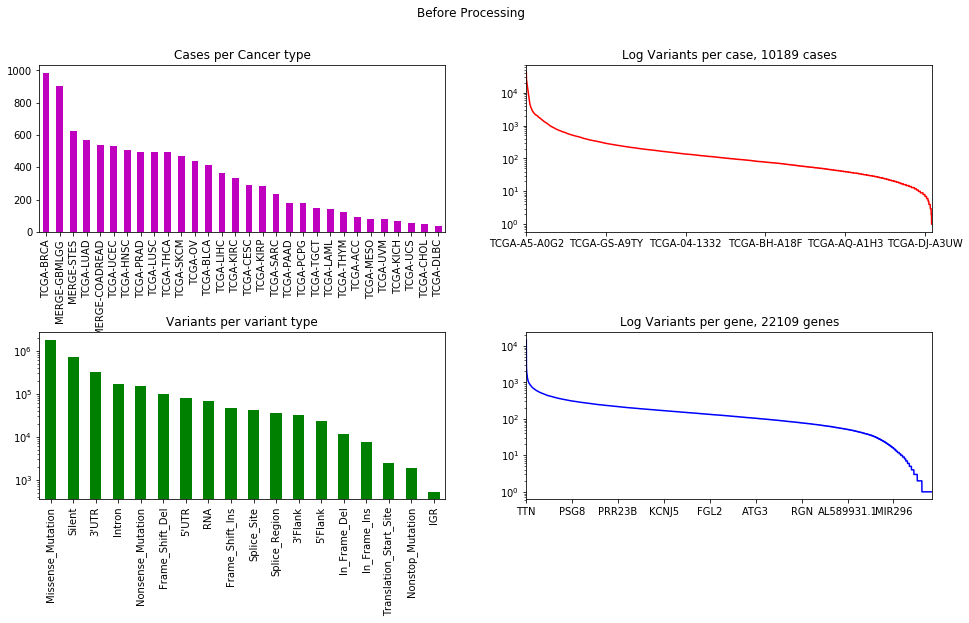

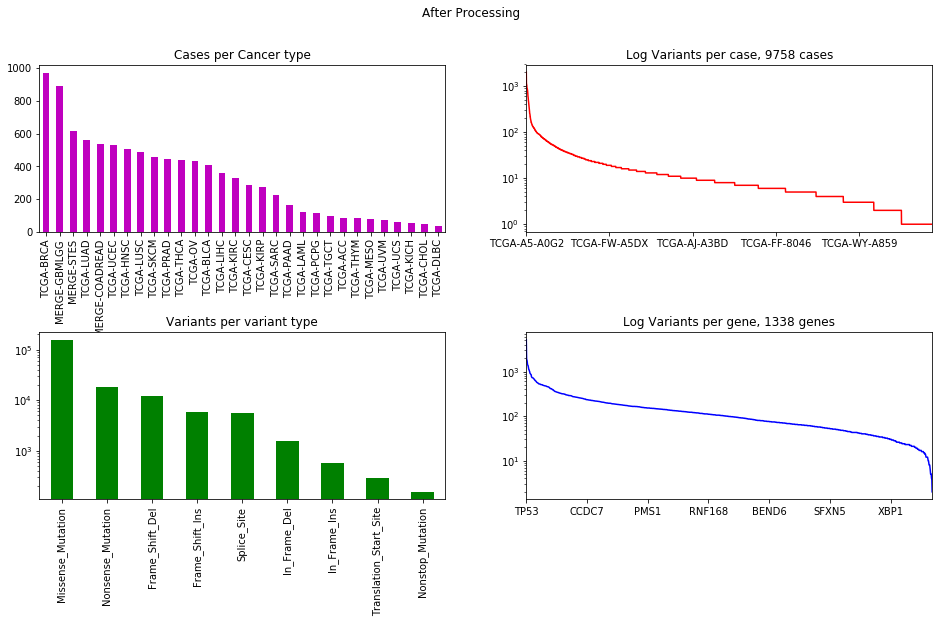

In [2]:
# load data
import pandas as pd
df_tcga = pd.read_csv(TCGA_MUT)

# process and filter
df_X    = (df_tcga.pipe(process_labels)
                  .pipe(filter_variants)
                  .pipe(filter_genes, by='mutsigcv', number=1348)
                  .pipe(dedup)
                  .pipe(reshape_pivot))

df_y    = (df_tcga.pipe(process_labels)
                  .pipe(filter_variants)
                  .pipe(filter_genes, by='mutsigcv', number=1348)
                  .pipe(get_label_df, df_X))

df_somatic = convert_to_onehot(df_X)

# visualise processing
(df_tcga.pipe(visualise_distributions, 'Before Processing'))
(df_tcga.pipe(process_labels)
        .pipe(filter_variants)
        .pipe(filter_genes, by='mutsigcv', number=1348)
        .pipe(visualise_distributions, 'After Processing'))

### Generate images

In [3]:
# from tools.gene2vec import load_embeddings, gene_intersection
# from tools.cluster  import init_algos, cluster_job, generate_imageset
# from tools.dataset  import generate_dataset
# from joblib import Parallel, delayed

# dims        = [32, 256]
# clustering  = ['MiniBatchKMeans']
# colours     = ['viridis']
# norms       = ['non-zero']

# for dim in dims:
#     # load gene vectors
#     filename = GENE2VEC / 'dim_{}/iter_10'.format(dim)
#     wv, vocab = load_embeddings(str(filename))
#     df_genevec = pd.DataFrame(wv.transpose(), columns=vocab)
#     genes = gene_intersection(df_somatic, df_genevec)
#     X = df_genevec[genes].values.transpose()
    
#     # get clusters in parallel from algos
#     algos = init_algos(X.transpose())
#     algos = tuple([algo for algo in algos if algo[0] in clustering])
#     clusters1 = Parallel()(delayed(cluster_job)((name, algo, X.transpose())) for name, algo in algos)
    
#     # get clusters in parallel from algos
#     algos = init_algos(X)
#     algos = tuple([algo for algo in algos if algo[0] in clustering])
#     clusters2 = Parallel()(delayed(cluster_job)((name, algo, X)) for name, algo in algos)
    
#     for i, alg in enumerate(clustering):
#         # create df_X and df_y
#         cluster1 = clusters1[i]
#         cluster2 = clusters2[i]
#         for norm in norms:
#             df_X = generate_imageset(df_genevec[genes], 
#                                      df_somatic[genes], 
#                                      cluster1, 
#                                      cluster2, 
#                                      norm)    
        
#             for colour in colours:
#                 # choose data dir
#                 data_dir = "../data/gene_images/2d_clustering/mutsigcv/dim={}_alg={}_norm={}_col={}" \
#                             .format(dim, alg, norm, colour)
                
#                 # generate dataset
#                 generate_dataset(df_X, df_y, data_dir, colour=colour)
                
#                 del df_X, X
#                 freememory()

### Thicken mutations

In [4]:
def thicken_mutations(image, buffer=1):
    """
    Algorithm: From left to right, if a gene has a free space next to it, occupy with that gene.
               Repeat procedure from right to left.
    """
    # while zero columns still exist
    import numpy as np
    array = image[0,:,0]
    for i in range(array.shape[0]):
        # check if row is not zero
        if ((np.mean(image[:,i,:], axis=(0,1)) - 0.4 >= 1e-4) \
            and (np.mean(image[:,(i+1):(i+1+buffer),:], axis=(0,1,2)) - (0.4) <= 1e-4) \
            and (i < array.shape[0] - 2)):
            image[:,i+1,:] = image[:,i,:]
    for j in range(array.shape[0])[::-1]:
        # check if row is not zero
        if ((np.mean(image[:,j,:], axis=(0,1)) - 0.4 >= 1e-4) \
            and (j > (buffer+1)) \
            and (np.mean(image[:,(j-1-buffer):(j-1),:], axis=(0,1,2)) - (0.4) <= 1e-4)):
            image[:,j-1,:] = image[:,j,:]
            
    return image

def plot_image(image, title='Image'):
    _ = plt.figure(figsize=(40,5))
    _.suptitle(title, size=16)
    plt.subplots_adjust(top=0.9)
    _ = plt.imshow(test_img, aspect='auto')

CPU times: user 220 ms, sys: 4 ms, total: 224 ms
Wall time: 223 ms


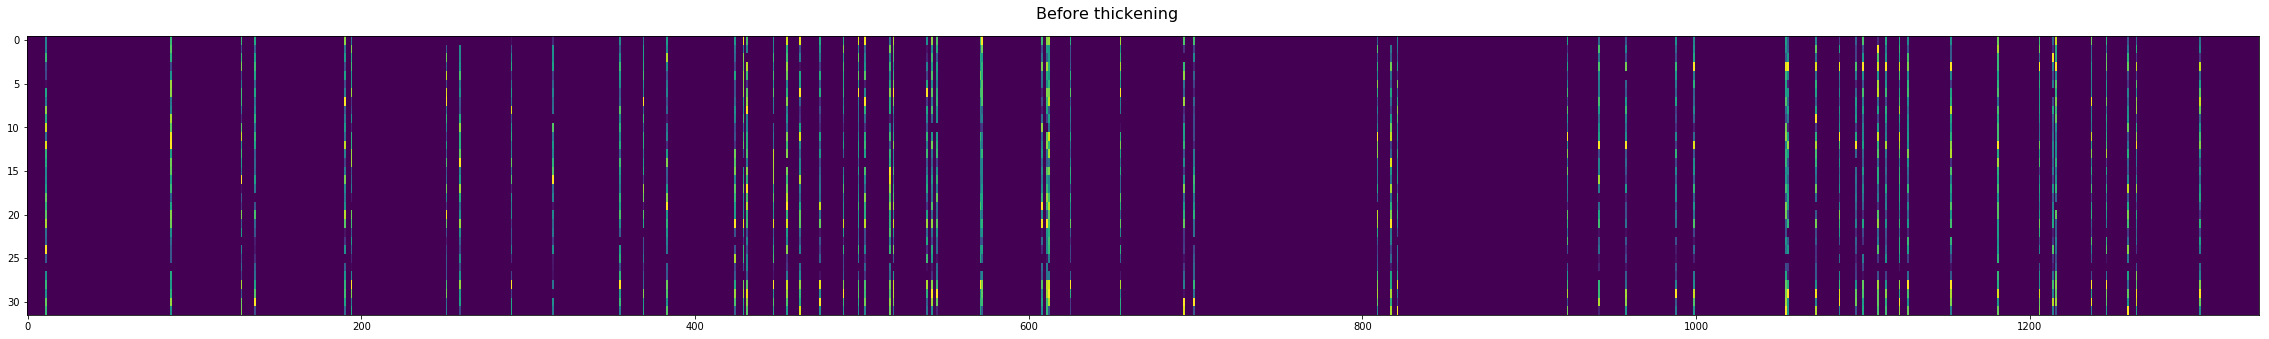

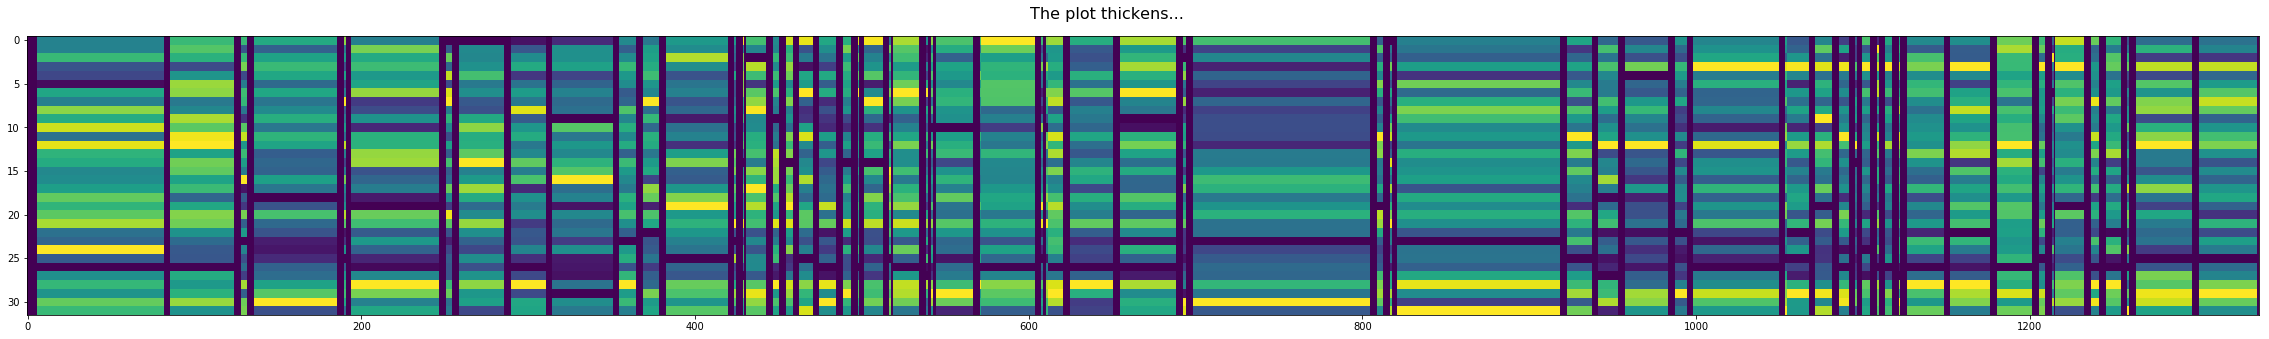

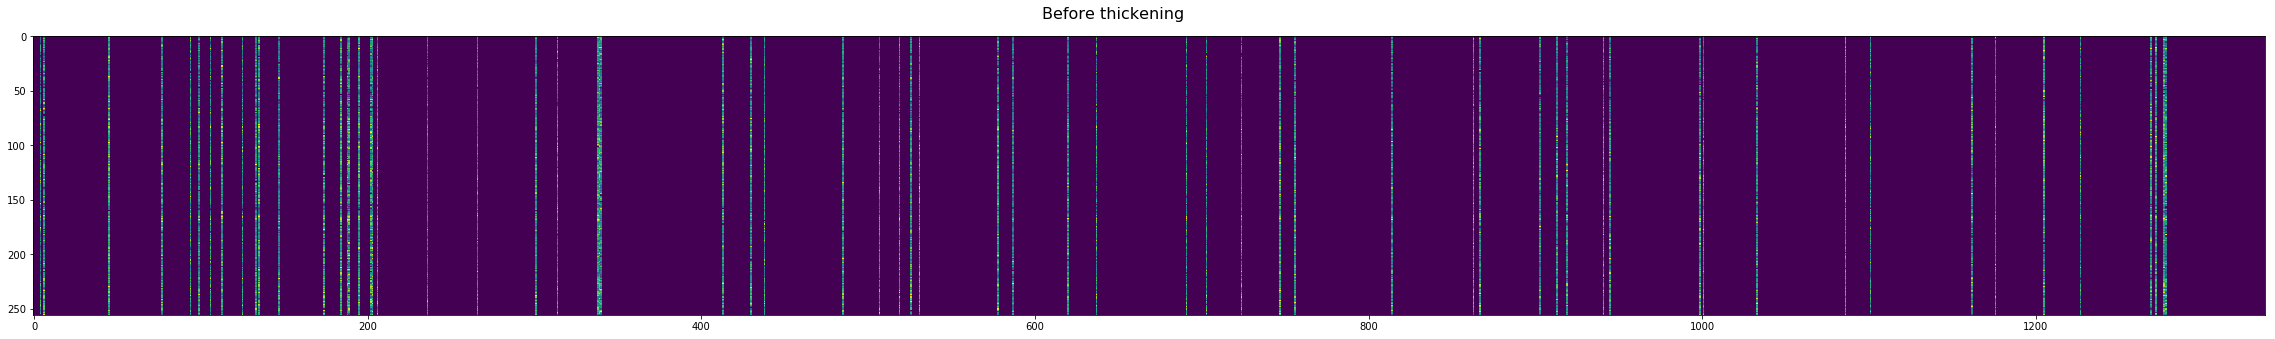

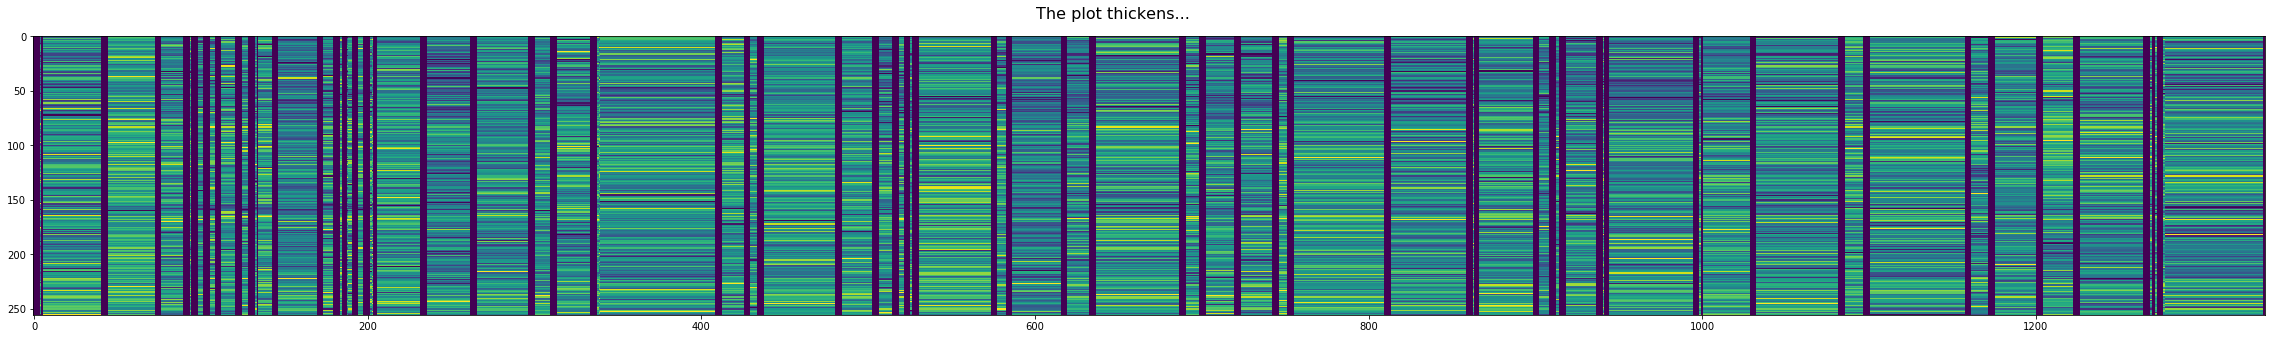

In [5]:
%%time
import matplotlib.image as img
import matplotlib.pyplot as plt

dims = (32, 256)

for dim in dims:
    test_img = img.imread('../data/gene_images/2d_clustering/mutsigcv/' + \
                          'dim={0}_alg=MiniBatchKMeans_norm=non-zero_col=viridis/valid/MERGE-STES/'.format(dim) + \
                          'TCGA-BR-6566.png')

    plot_image(test_img, title='Before thickening')
    thicken_mutations(test_img, buffer=5)
    plot_image(test_img, title='The plot thickens...')

Generate alternate dataset of thickened mutations.

In [35]:
datasets    = ['../data/gene_images/2d_clustering/mutsigcv/dim=32_alg=MiniBatchKMeans_norm=non-zero_col=viridis',
               '../data/gene_images/2d_clustering/mutsigcv/dim=256_alg=MiniBatchKMeans_norm=non-zero_col=viridis']

outdir      = '../data/gene_images/2d_clustering/mutsigcv_thickened'

def thicken_dataset(indir, outdir):
    from pathlib import Path
    import matplotlib.image as img

    for filename in Path(indir).glob('**/*.png'):
        image = img.imread(str(filename))
        thicken_mutations(image, buffer=5)
        
        savedir = Path(outdir) / "/".join(str(filename).split('/')[5:-1])
        outfile = Path(outdir) / "/".join(str(filename).split('/')[5:])
        Path.mkdir(savedir, parents=True, exist_ok=True)
        img.imsave(outfile, image)

for dataset in datasets:
    thicken_dataset(dataset, outdir)

/home/athon/.conda/envs/thesis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/athon/.conda/envs/thesis/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
